In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!sudo unzip "/content/drive/MyDrive/vos/train.zip" -d "/content/vos"

## Visualize Utils

In [ ]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image

def visualize(image_path, anchor_boxes):

  image = Image.open(image_path)
  image = image.resize((800, 800))

  image = np.array(image)

  for i_box, box in enumerate(anchor_boxes):
    
    start_point = (int(box[0]), int(box[1]))
    end_point = (int(box[2]), int(box[3]))
    
    cv2.rectangle(image, start_point, end_point, (255, 0, 0), 2)
    plt.imshow(image)

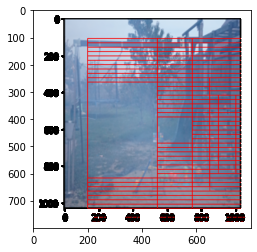

In [ ]:
## UNIT TEST
# visualize("/content/0_15_hazy.png", anchor_boxes[20000:20100])

In [ ]:
def visualize_a_box(image_path, box):
  visualize(image_path, [box])

## Generate Anchor Boxes

In [21]:
import numpy as np

In [22]:
subsample = 16
scales = [8, 16, 32]
ratios = [0.5, 1, 2]

In [23]:
def gen_anchor_box_for_single_feature_map(center_X, center_Y, scales, ratios):
  
  k = 0
  boxes = np.zeros((len(scales) * len(ratios), 4))

  for ratio in ratios:
    
    for scale in scales:

      W = scale * subsample * ratio
      H = scale * subsample

      x_left_top = center_X - (1/2) * W
      y_left_top = center_Y - (1/2) * H

      x_right_bottom = center_X + (1/2) * W
      y_right_bottom = center_Y + (1/2) * H 

      boxes[k, 0] = x_left_top
      boxes[k, 1] = y_left_top
      boxes[k, 2] = x_right_bottom
      boxes[k, 3] = y_right_bottom

      k += 1

  return boxes


In [24]:
## UNIT TEST
#gen_anchor_box_for_single_feature_map(400, 400, [8, 16, 32], [0.5, 1, 2]) # output has to be in shape of (3 * 3, 4)

In [25]:
anchor_boxes = np.zeros((50, 50, len(scales) * len(ratios), 4)) 
# center_X, center_Y
for i, center_X in enumerate(np.arange(8, 16 * (50), 16 )):
  for j, center_Y in enumerate(np.arange(8, 16 * (50), 16)):
    anchor_boxes[i, j] = gen_anchor_box_for_single_feature_map(center_X, center_Y, scales, ratios)

In [26]:
anchor_boxes = anchor_boxes.reshape(-1, 4)
anchor_boxes.shape

(22500, 4)

## Compute IoU

In [ ]:
def compute_iou(box1, box2):
  # assumeing boxes are in format (x1, y1, x2, y2)
  inter = {}
  inter["x_left_top"] = max(box1[0], box2[0])
  inter["y_left_top"] = max(box1[1], box2[1])

  inter["x_right_bottom"] = min(box1[2], box2[2])
  inter["y_right_bottom"] = min(box1[3], box2[3])

  if inter["x_left_top"] < inter["x_right_bottom"] and inter["y_left_top"] < inter["y_right_bottom"]: # there is a non-zero intersection  
    iou_area = (inter["x_right_bottom"] - inter["x_left_top"]) * (inter["y_right_bottom"] - inter["y_left_top"])
  else:
    iou_area = 0

  box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
  box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

  iou = iou_area / (box1_area + box2_area - iou_area)

  return iou

In [ ]:
## UNIT TEST
# box1 = [0, 0, 5, 5]
# box2 = [5, 5, 10, 10]
# box3 = [2.5, 2.5, 7.5, 7.5]

# compute_iou(box1, box2) # it has to be zero
# compute_iou(box1, box3) # ~ 0.14
# compute_iou(box3, box1) # it's a symetric function so same 0.14

## Get Bouning Box from Mask

In [ ]:
from PIL import Image

def get_bounding_box(image_path, mask_path):

  image = Image.open(image_path)
  mask = Image.open(mask_path)
  
  image = image.resize((800, 800)) # otherwise boxes don't place at right locations 
  mask = mask.resize((800, 800))

  mask = np.array(mask)

  # mask is in shape of [H, W] where each pixel has a value of 0, 1, 2, 3, 4
  # we don't care about different categories, we care just about being an object

  boxes = []
  
  for instance_number in range(1, np.max(mask) + 1):
    Y, X = np.where(mask == instance_number)
    box = [X.min(), Y.min(), X.max(), Y.max()]
    boxes.append(box)
  
  return boxes

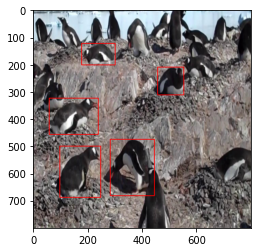

In [ ]:
# UNIT TEST
boxes = get_bounding_box("/content/image.jpg", "/content/label.png")
visualize("/content/image.jpg", boxes)

## Compute (50 * 50 * 9, 2)

In [ ]:
def get_anchors_iou(image_path, label_path):
  
  gt_boxes = get_bounding_box(image_path, label_path)

  anchors_iou = np.zeros((len(anchor_boxes), len(gt_boxes)))

  for anchor_ind, anchor_box in enumerate(anchor_boxes):
    for gt_idx, gt_box in enumerate(gt_boxes):
      anchors_iou[anchor_ind, gt_idx] = compute_iou(anchor_box, gt_box)
  
  return anchors_iou    

In [ ]:
def iou_to_label(anchors_iou):

  # anchors_iou is the mutual iou of every anchor box and ground-truth box
  # is in shape of (50 * 50 * 9, 5)

  # output is in shape of (50 * 50 * 9, 1)

  """
  a) if iou of anchor box and ground-truth box is greater than 0.7 label one is assigned
  b) anchor box with highest iou with a specific ground-truth box is also labeled as one
  c) iou less than 0.3 is labeled as -1
  """


  anchor_label = np.full((anchors_iou.shape[0], 1), fill_value=-1)

  # higher_iou_idx, higher_gt_idx = np.where(anchors_iou > 0.7) # a rule
  # lower_iou_idx, lower_gt_idx = np.where(anchors_iou < 0.3) # b rule

  negative_a_idx = np.where(np.max(anchors_iou, axis=-1) < 0.3) # a rule
  
  positive_b_idx = np.where(np.max(anchors_iou, axis=-1) > 0.7) # b rule
  postive_c_idx =  np.argmax(anchors_iou, axis=0) # c rule
  
  anchor_label[positive_b_idx, :] = 1
  anchor_label[postive_c_idx, :] = 1
  
  anchor_label[negative_a_idx, :] = 0
  
  return anchor_label

(array([], dtype=int64),)
[ 4816 10216  3819 14088  6384]


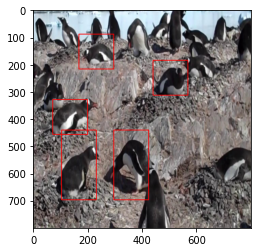

In [ ]:
# UNIT TEST
anchors_iou = get_anchors_iou("/content/image.jpg", "/content/label.png")
anchor_label = iou_to_label(anchors_iou)
X1, _ = np.where(anchor_label == 1)
visualize("/content/image.jpg", anchor_boxes[X1])

In [ ]:
# SANITY CHECK
# anchors with label zero should be much higher in number than label 1 and -1
# label 1 reasonable range is (grouth_truth, 3 * grouth_truth)

(anchor_label == -1).sum(), (anchor_label == 0).sum(), (anchor_label == 1).sum() 

(1090, 21405, 5)

## Locations

In [19]:
def corner2center(box):

  x1 = box[0]
  x2 = box[2]

  y1 =  box[1]
  y2 = box[3]

  center_x, center_y = (x1 + x2) / 2, (y1 + y2) / 2
  width, height = (x2 - x1), (y2 - y1)

  return [center_x, center_y, width, height]

In [ ]:
# UNIT TEST
# box1 = corner2center([0, 0, 5, 5]) 
# assert box1 == [2.5, 2.5, 5, 5]
# print("pass!")

In [ ]:
from math import log

def get_location(anchor_box, gt_box):
  
  # input is anchor_box, gt_box in center format
  # output is t_X, t_y, t_h, t_w

  t_x = (anchor_box[0] - gt_box[0]) / anchor_box[2]
  t_y = (anchor_box[1] - gt_box[1]) / anchor_box[3]
  t_w = log(gt_box[2] / anchor_box[2])
  t_h = log(gt_box[3] / anchor_box[3])

  return [t_x, t_y, t_w, t_h] 


In [ ]:
# UNIT TEST
# box1 = corner2center([0., 0., 5., 5.])
# box2 = corner2center([2.5, 2.5, 7.5, 7.5])

# assert (get_location(box1, box2) == [-1/2, -1/2, 0, 0]) # expected output [-1/2, -1/2, 0, 0]
# print("pass!")

In [ ]:
# for each anchor box we have (t_x, t_y, t_w, t_h)
# ground truth box with highest iou is chosen
loc = np.zeros((len(anchor_boxes), 4)) 

In [ ]:
anchors_iou = get_anchors_iou("/content/image.jpg", "/content/label.png") # (number of anchors, number of gt_boxes)
highest_iou = np.argmax(anchors_iou, axis=-1) # only GT-box with highest IoU is considered

In [ ]:
gt_boxes = get_bounding_box("/content/image.jpg", "/content/label.png")

In [ ]:
from tqdm.auto import tqdm

for anchor_idx in tqdm(range((len(anchor_boxes)))):
  
  anchor_center = corner2center(anchor_boxes[anchor_idx]) 
  gt_center = corner2center(gt_boxes[highest_iou[anchor_idx]]) # coordination of nearest GT-box

  loc[anchor_idx] = get_location(anchor_center, gt_center)

  0%|          | 0/22500 [00:00<?, ?it/s]

In [ ]:
print(loc.shape, label.shape)

(22500, 4) (22500,)


## RPN Network

In [1]:
import torch
import torch.nn as nn
from torchvision.models import vgg16

In [2]:
class RPN(nn.Module):
  
  def __init__(self, n_anchors):
    
    super(RPN, self).__init__()
    
    self.feature_extractor = vgg16(pretrained=True).features[:30]
    
    self.conv1 = nn.Conv2d(512, 512, 3, 1, 1)

    self.cls_layer = nn.Conv2d(512, n_anchors * 2, 1, 1, 0)
    self.reg_layer = nn.Conv2d(512, n_anchors * 4, 1, 1, 0)

  
  def forward(self, x):

    x = self.feature_extractor(x)
    x = self.conv1(x)

    pred_cls = self.cls_layer(x)
    pred_loc = self.reg_layer(x)

    return pred_cls, pred_loc

In [3]:
# n_anchors = len(scales) * len(ratios)
n_anchors = 9
rpn = RPN(n_anchors)

In [4]:
# UNIT Test
# assert (rpn.feature_extractor(torch.randn(4, 3, 800, 800)).shape) == (4, 512, 50, 50), "something wrong with feature extractor output shape!"

In [13]:
pred_cls, pred_loc = rpn(torch.randn(1, 3, 800, 800)) # output should be (1, 18, 50 , 50), (50 * 50 * 9 * 4, 4)

pred_loc = pred_loc.contiguous().view(1, -1, 4)
pred_cls = pred_cls.permute(0, 2, 3, 1).contiguous().view(1, 50, 50, 18)
objectness_score = pred_cls.view(1, 50 * 50, 9, 2)[:, :, :, 1].contiguous().view(1, -1)
pred_cls = pred_cls.view(1, -1, 2)

pred_cls.shape, pred_loc.shape, objectness_score.shape 

(torch.Size([1, 22500, 2]), torch.Size([1, 22500, 4]), torch.Size([1, 22500]))

## Post Process

$$ t_x = \frac{A_x - G_x}{A_w} $$
\
$$ t_w = \log{\frac{G_w}{A_w}} $$

In [14]:
import numpy as np

In [15]:
def center2corner(box):
  x, y, w, h = box
  x1 = x - (1/2) * w
  y1 = y - (1/2) * h
  x2 = x + (1/2) * w
  y2 = y + (1/2) * h

  return [x1, y1, x2, y2]

In [16]:
pred_loc = pred_loc[0].detach().numpy()

In [17]:
pred_location_convert = np.zeros_like(pred_loc)

In [27]:
from tqdm.auto import tqdm

for idx, pred in enumerate(tqdm(pred_loc)):
  A_x, A_y, A_w, A_h = corner2center(anchor_boxes[idx])
  t_x, t_y, t_w, t_h = pred

  x = A_x - (t_x * A_w)
  y = A_y - (t_y * A_y)
  w = np.exp(t_w) * A_w
  h = np.exp(t_h) * A_h

  x1, y1, x2, y2 = center2corner([x, y, w, h])
  pred_location_convert[idx] = [x1, y1, x2, y2]


  0%|          | 0/22500 [00:00<?, ?it/s]

In [28]:
pred_location_convert.shape

(22500, 4)

## Clip to the Image

## Filter Region Size

## Sort Scores

In [42]:
order = objectness_score.ravel().argsort(descending=True)
order

tensor([361, 352, 796,  ..., 899, 436,  22])